# Previsão do Preço do Bitcoin com LSTM

### Discente(s):

    Bruno Antonio dos Santos Bezerra
    Erick Vinicius Rebouças Cruz
    Gabriel Monteiro Lobão

### Framework:
    TensorFlow/Keras

### Requerimentos:
    1. Python 3.9
    2. Tensorflow (conda install -c conda-forge tensorflow-gpu=2.10)
    3. Pandas
    4. Matplotlib
    5. Sklearn
    6. Numpy
    7. Dataset: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

### Etapas do Projeto:
    1. Carregamento e Exploração dos Dados
    2. Pré-processamento
    3. Otimização de Hiperparâmetros com Optuna
    4. Analisando dados encontrados
    5. Criação do Modelo LSTM
    6. Treinamento e Validação do Modelo
    7. Avaliação e Previsões
    8. Previsão Futura (Exemplo)

# Importação de Bibliotecas

In [1]:
import numpy as np # Manipulação de dados numéricos e estruturados.
import pandas as pd
import matplotlib.pyplot as plt # Geração de gráficos.
from sklearn.preprocessing import MinMaxScaler # Normalização dos dados e métricas.
from tensorflow.keras.models import Sequential # Construção da rede neural com LSTM.
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import optuna # Otimização de hiperparâmetros.
from tensorflow.keras.optimizers import Adam # Algoritmo de otimização para treinar a rede neural.
from sklearn.metrics import r2_score # Avaliação da precisão do modelo.

2025-02-10 10:15:28.301123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/yienvee/anaconda3/envs/tensorflow-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Carregamento e Exploração dos Dados

In [2]:
# Carregar o arquivo CSV
df = pd.read_csv('btcusd_1-min_data.csv')
df

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6750276,1.737936e+09,102628.00,102669.00,102608.00,102611.00,0.086742
6750277,1.737936e+09,102659.00,102712.00,102657.00,102712.00,0.488757
6750278,1.737936e+09,102631.00,102631.00,102573.00,102573.00,0.126719
6750279,1.737936e+09,102573.00,102604.00,102507.00,102514.00,0.474495


In [3]:
# Converter timestamp para datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume,date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [4]:
print("\nInformações do Dataset:")
df.info()


Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750281 entries, 0 to 6750280
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  float64       
 1   Open       float64       
 2   High       float64       
 3   Low        float64       
 4   Close      float64       
 5   Volume     float64       
 6   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 360.5 MB


## Pré-processamento Inicial

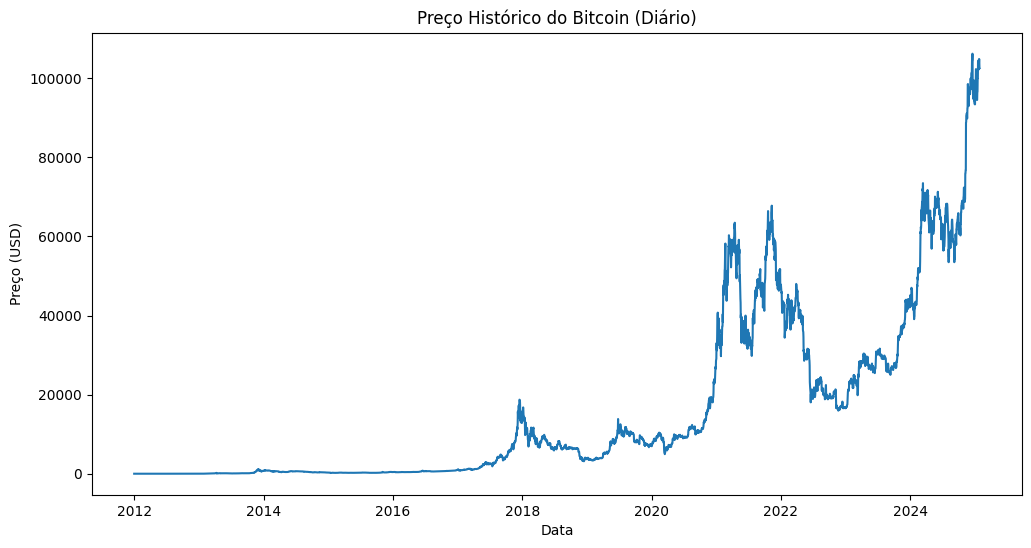

In [5]:
# Converter dados de 1 minuto para diários
df_daily = df.resample('D', on='date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',

}).dropna()

# Plot do preço de fechamento
plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily['Close'])
plt.title('Preço Histórico do Bitcoin (Diário)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.show()

# 2. Pré-processamento para LSTM

In [6]:
# Usaremos apenas o preço de fechamento
data = df_daily[['Close']].values

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Divisão entre treino e teste
# 80% treino, 20% teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [7]:
# Função para criar sequências
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data)-seq_length-1):
        x.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(x), np.array(y)

SEQ_LENGTH = 60  # Janela temporal de 60 dias
x_train, y_train = create_sequences(train_data, SEQ_LENGTH)
x_test, y_test = create_sequences(test_data, SEQ_LENGTH)

In [8]:
# Reshape dos dados para que a LSTM possa processá-los.
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 3. Otimização de Hiperparâmetros com Optuna

In [ ]:
def objective(trial):
    # Sugerir o número de camadas LSTM (entre 1 e 3)
    n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 3)

    model = Sequential()

    # Adicionar as camadas LSTM dinamicamente
    for i in range(n_lstm_layers):
        lstm_units = trial.suggest_int(f"lstm_units_{i}", 25, 200, step=10)
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.1, 0.5, step=0.1)
        return_sequences = (i < n_lstm_layers - 1)

        if i == 0:
            model.add(LSTM(lstm_units, return_sequences=return_sequences, input_shape=(SEQ_LENGTH, 1)))
        else:
            model.add(LSTM(lstm_units, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))

    # Camada Dense intermediária
    dense_units = trial.suggest_int('dense_units', 10, 100, step=10)
    model.add(Dense(dense_units, activation='relu'))

    # Camada de saída
    model.add(Dense(1))

    # Outros hiperparâmetros
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,            # Usando 100 épocas para acelerar os trials
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    # Obter o menor valor de loss da validação
    val_loss = min(history.history['val_loss'])

    # Calcular a precisão (R² score) no conjunto de teste
    y_pred = model.predict(X_test)
    test_accuracy = r2_score(y_test, y_pred)

    # Salvar a precisão no trial para que seja exportada junto com os demais parâmetros
    trial.set_user_attr("test_accuracy", test_accuracy)

    return val_loss

# Criar estudo e executar os trials
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=250)

In [ ]:
# Exibir o melhor trial encontrado
print("Melhor Trial:")
print("Parâmetros:", study.best_trial.params)
print("Validação Loss:", study.best_trial.value)
print("Precisão (R²) no conjunto de teste:", study.best_trial.user_attrs["test_accuracy"])

# Gerar DataFrame com os resultados dos trials (a coluna 'user_attrs_test_accuracy' aparecerá)
df_trials = study.trials_dataframe()

# Salvar em Excel (certifique-se de ter o pacote 'openpyxl' instalado)
df_trials.to_excel("optuna_results.xlsx", index=False)
print("Resultados do Optuna salvos no arquivo 'optuna_results.xlsx'.")

### Melhor Trial:
Parâmetros: {\
\
**'n_lstm_layers'**: 1,\
**'lstm_units_0'**: 195,\
**'dropout_rate_0'**: 0.1,\
**'dense_units'**: 60,\
**'batch_size'**: 16,\
**'learning_rate'**: 0.0038802356576285594\
\
}

**Validação Loss**: 0.00020527467131614685\
**Precisão (R²) no conjunto de teste**: 0.9950849153720213

    Resultados do Optuna salvos no arquivo 'optuna_results.xlsx'.

# 4. Analisando dados encontrados

In [9]:
data_optuna  =  pd.read_excel('optuna_results.xlsx')
data_optuna.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dense_units,params_dropout_rate_0,params_dropout_rate_1,params_dropout_rate_2,params_learning_rate,params_lstm_units_0,params_lstm_units_1,params_lstm_units_2,params_n_lstm_layers,user_attrs_test_accuracy,state
0,0,0.004629,2025-02-08 16:44:30.103,2025-02-08 16:44:39.744,0.000112,128,30,0.2,0.5,0.5,0.001523,115,65.0,55.0,3,0.728350,COMPLETE
1,1,0.002122,2025-02-08 16:44:39.745,2025-02-08 16:44:52.169,0.000144,80,80,0.4,0.5,0.2,0.000315,75,135.0,115.0,3,0.923761,COMPLETE
2,2,0.000832,2025-02-08 16:44:52.170,2025-02-08 16:45:12.316,0.000233,16,100,0.2,0.5,NaN,0.000943,145,125.0,NaN,2,0.972629,COMPLETE
3,3,0.001239,2025-02-08 16:45:12.317,2025-02-08 16:45:32.591,0.000235,32,20,0.2,NaN,NaN,0.000042,185,NaN,NaN,1,0.957565,COMPLETE
4,4,0.001922,2025-02-08 16:45:32.592,2025-02-08 16:45:42.798,0.000118,80,70,0.5,NaN,NaN,0.000304,65,NaN,NaN,1,0.927564,COMPLETE


In [10]:
data_optuna = data_optuna.drop(columns=['datetime_start','datetime_complete','state', 'number'])
data_optuna.sort_values('user_attrs_test_accuracy')

,value,duration,params_batch_size,params_dense_units,params_dropout_rate_0,params_dropout_rate_1,params_dropout_rate_2,params_learning_rate,params_lstm_units_0,params_lstm_units_1,params_lstm_units_2,params_n_lstm_layers,user_attrs_test_accuracy
79,0.026616,0.000604,16,90,0.1,NaN,NaN,0.008604,195,NaN,NaN,1,-4.542393
40,0.009594,0.000357,16,80,0.1,0.4,NaN,0.001855,185,25.0,NaN,2,0.490777
130,0.006675,0.000354,16,100,0.1,0.4,NaN,0.005592,185,25.0,NaN,2,0.671451
0,0.004629,0.000112,128,30,0.2,0.5,0.5,0.001523,115,65.0,55.0,3,0.728350
9,0.005043,0.000163,128,100,0.1,0.2,0.2,0.000285,65,45.0,35.0,3,0.752893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.000225,0.000375,16,100,0.1,NaN,NaN,0.002641,195,NaN,NaN,1,0.996561
217,0.000227,0.000311,16,100,0.1,NaN,NaN,0.002718,185,NaN,NaN,1,0.996586
158,0.000217,0.000333,16,40,0.1,NaN,NaN,0.002449,95,NaN,NaN,1,0.996672
94,0.000222,0.000279,16,100,0.1,NaN,NaN,0.002964,85,NaN,NaN,1,0.996781


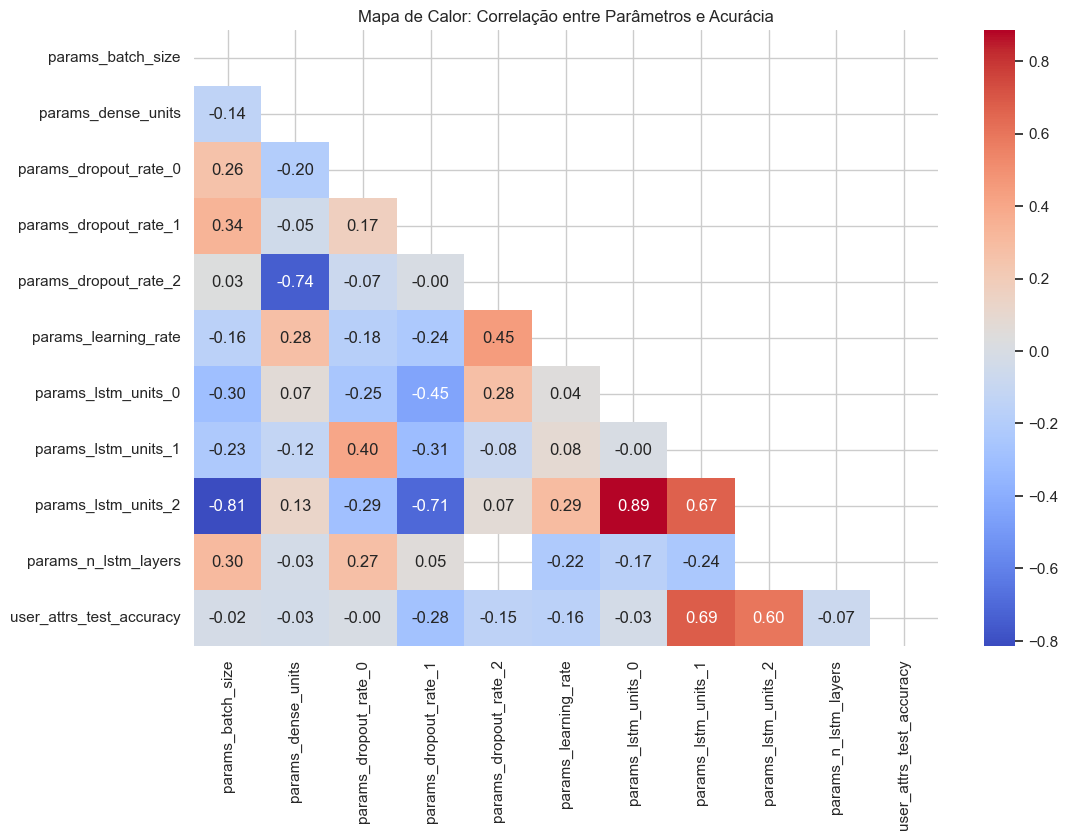

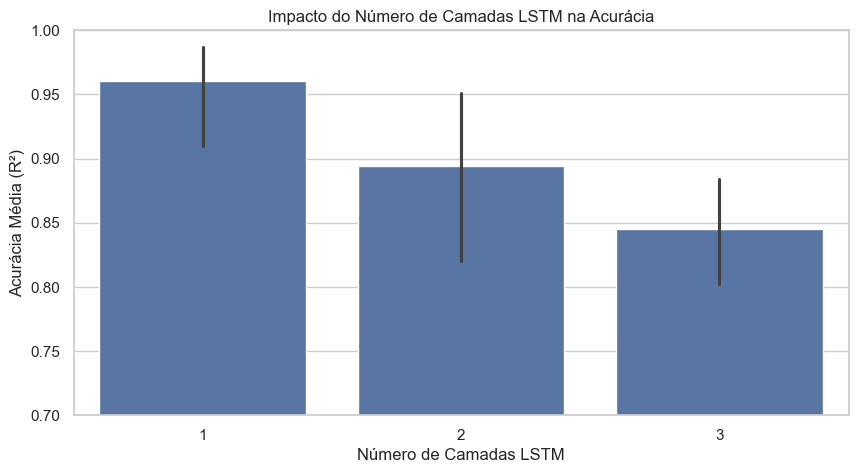

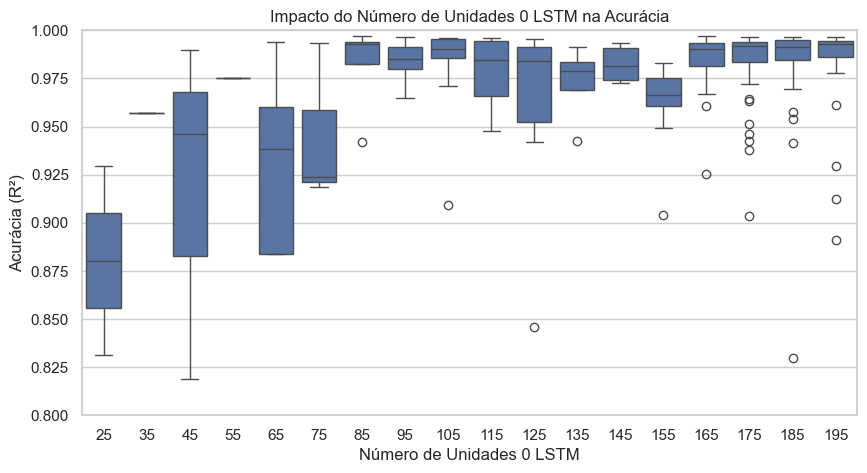

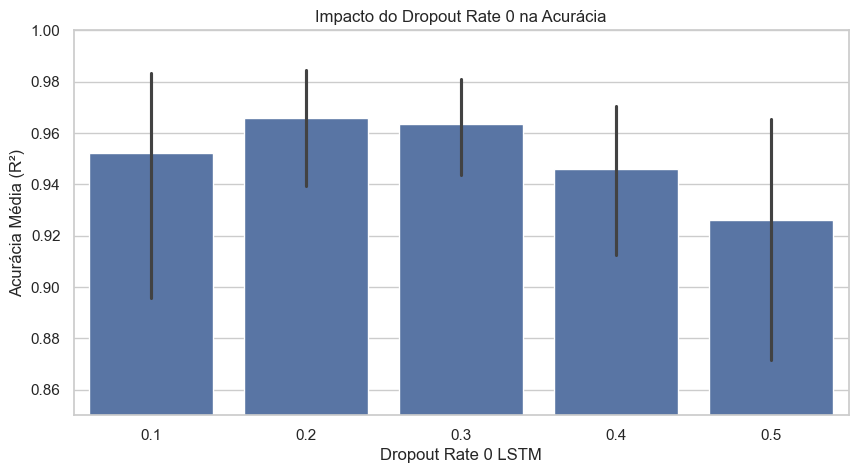

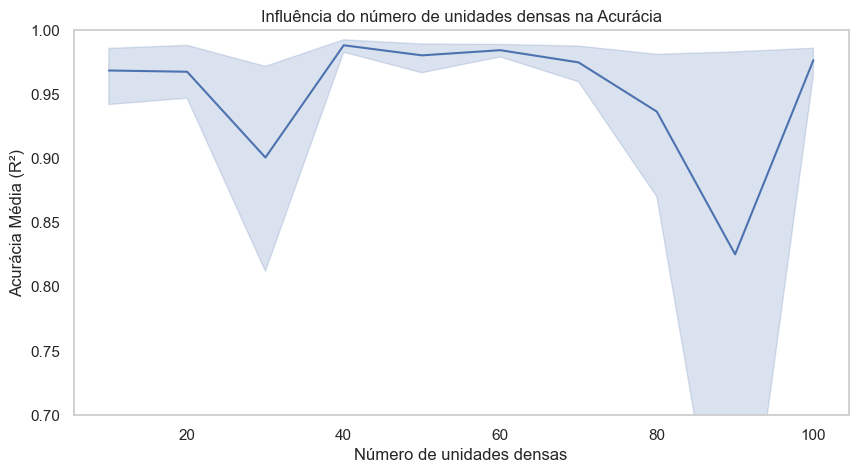

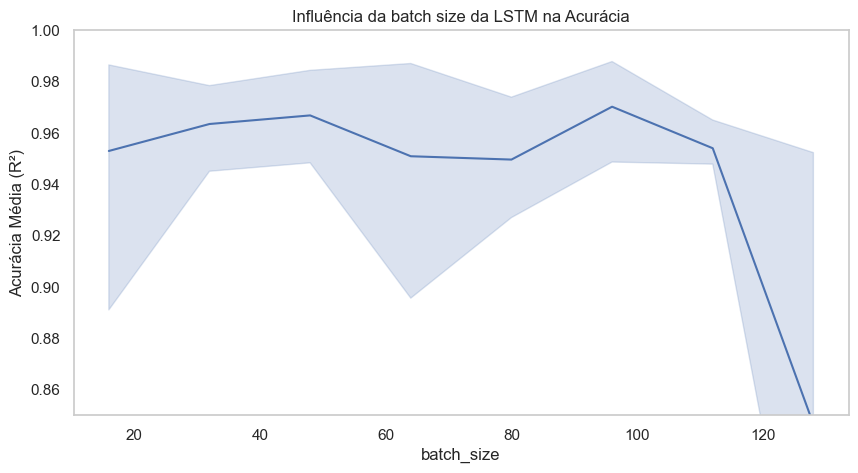

(0.8, 1.0)

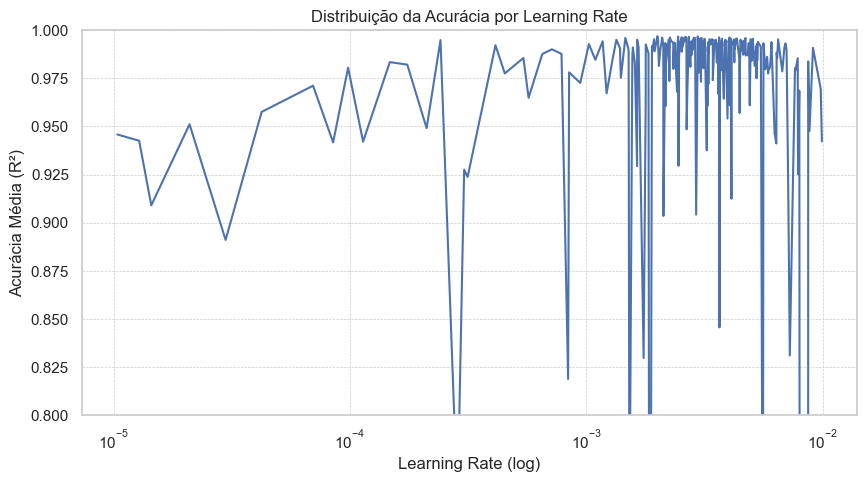

In [ ]:
# Gráficos aqui:
# Utilizaremos o coeficiente de determinação R² (R-squared)
# O R² mede a proporção da variabilidade dos dados que o modelo explica. Ele varia entre -∞ e 1:
# R² = 1 → O modelo prevê os valores perfeitamente.
# R² = 0 → O modelo não tem poder preditivo melhor do que a média dos dados.
# R² < 0 → O modelo é pior do que um chute baseado na média.

import seaborn as sns

graf = pd.read_excel("optuna_results.xlsx")

graf = graf.drop(columns=['datetime_start','datetime_complete','state', 'number', 'value', 'duration'])

correlation_matrix = graf.corr()

# Criar máscara para ocultar a parte superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Criar o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor: Correlação entre Parâmetros e Acurácia")
plt.show()

# 2. Gráfico de barras: Número de camadas LSTM vs Acurácia Média
plt.figure(figsize=(10, 5))
sns.barplot(x=graf['params_n_lstm_layers'], y=graf['user_attrs_test_accuracy'])
plt.xlabel("Número de Camadas LSTM")
plt.ylabel("Acurácia Média (R²)")
plt.ylim(0.7, 1)
plt.title("Impacto do Número de Camadas LSTM na Acurácia")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=graf['params_lstm_units_0'], y=graf['user_attrs_test_accuracy'])
plt.xlabel("Número de Unidades 0 LSTM")
plt.ylabel("Acurácia (R²)")
plt.ylim(0.8, 1)
plt.title("Impacto do Número de Unidades 0 LSTM na Acurácia")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=graf['params_dropout_rate_0'], y=graf['user_attrs_test_accuracy'])
plt.xlabel("Dropout Rate 0 LSTM")
plt.ylabel("Acurácia Média (R²)")
plt.ylim(0.85, 1)
plt.title("Impacto do Dropout Rate 0 na Acurácia")
plt.show()

# 3. Gráficos de linha:
plt.figure(figsize=(10, 5))
sns.lineplot(x=graf['params_dense_units'], y=graf['user_attrs_test_accuracy'])
plt.xlabel("Número de unidades densas")
plt.ylabel("Acurácia Média (R²)")
plt.ylim(0.7,1)
plt.title("Influência do número de unidades densas na Acurácia")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(x=graf['params_batch_size'], y=graf['user_attrs_test_accuracy'])
plt.xlabel("batch_size")
plt.ylabel("Acurácia Média (R²)")
plt.ylim(0.85,1)
plt.title("Influência da batch size da LSTM na Acurácia")
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(x=graf["params_learning_rate"], y=graf["user_attrs_test_accuracy"])
plt.xscale("log")  # Escala logarítmica para melhor visualização do learning rate
plt.xlabel("Learning Rate (log)")
plt.ylabel("Acurácia Média (R²)")
plt.title("Distribuição da Acurácia por Learning Rate")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.ylim(0.80,1)



# 5. Criação do Modelo LSTM

In [11]:
# Modelo final baseado nos melhores hiperparâmetros.
model = Sequential()
model.add(LSTM(165, return_sequences=False, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.1))
model.add(Dense(60))
model.add(Dense(1))

2025-02-10 10:16:06.342570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 10:16:06.461039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 10:16:06.463653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-10 10:16:06.466277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [12]:
model.compile(optimizer=Adam(learning_rate=0.002001), loss='mean_squared_error')

# Visualizar arquitetura
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 165)               110220    
                                                                 
 dropout (Dropout)           (None, 165)               0         
                                                                 
 dense (Dense)               (None, 60)                9960      
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 120,241
Trainable params: 120,241
Non-trainable params: 0
_________________________________________________________________


# 6. Treinamento e Validação do Modelo

In [13]:
# Setando a parada do modelo
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

Epoch 1/300
 12/188 [>.............................] - ETA: 0s - loss: 4.4275e-04

2025-02-10 10:16:53.356808: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907


188/188 [==============================] - 2s 6ms/step - loss: 5.2211e-05 - val_loss: 8.2220e-04
Epoch 2/300
188/188 [==============================] - 1s 5ms/step - loss: 2.0773e-05 - val_loss: 3.7519e-04
Epoch 3/300
188/188 [==============================] - 1s 5ms/step - loss: 1.7207e-05 - val_loss: 2.9030e-04
Epoch 4/300
188/188 [==============================] - 1s 5ms/step - loss: 1.5307e-05 - val_loss: 3.2735e-04
Epoch 5/300
188/188 [==============================] - 1s 5ms/step - loss: 1.6446e-05 - val_loss: 6.2985e-04
Epoch 6/300
188/188 [==============================] - 1s 5ms/step - loss: 1.7961e-05 - val_loss: 2.3081e-04
Epoch 7/300
188/188 [==============================] - 1s 5ms/step - loss: 1.4006e-05 - val_loss: 2.4120e-04
Epoch 8/300
188/188 [==============================] - 1s 5ms/step - loss: 1.7566e-05 - val_loss: 3.8013e-04
Epoch 9/300
188/188 [==============================] - 1s 5ms/step - loss: 1.2139e-05 - val_loss: 2.2747e-04
Epoch 10/300
188/188 [=========

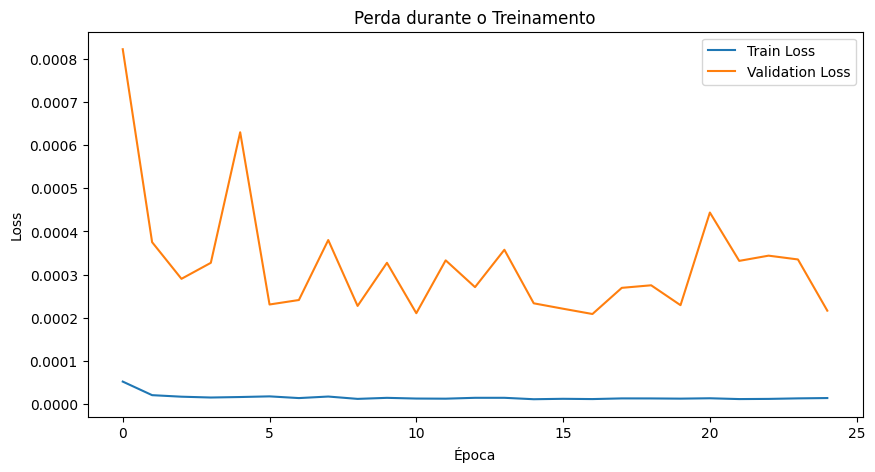

In [14]:
# Aumento de épocas e batch size
# Treinamento com 300 épocas e batch de 16.
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot da perda durante o treinamento
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

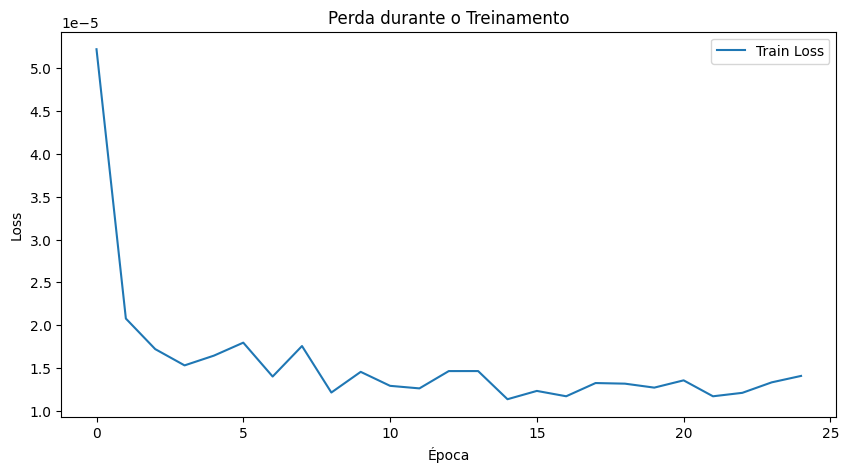

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Avaliação e Previsões

In [16]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverter a normalização
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])

28/28 [==============================] - 0s 2ms/step


In [17]:
# Deslocar as previsões de treino para alinhar visualmente
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[SEQ_LENGTH:len(train_predict)+SEQ_LENGTH, :] = train_predict

# Deslocar as previsões de teste
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(SEQ_LENGTH*2)+1:len(data)-1, :] = test_predict

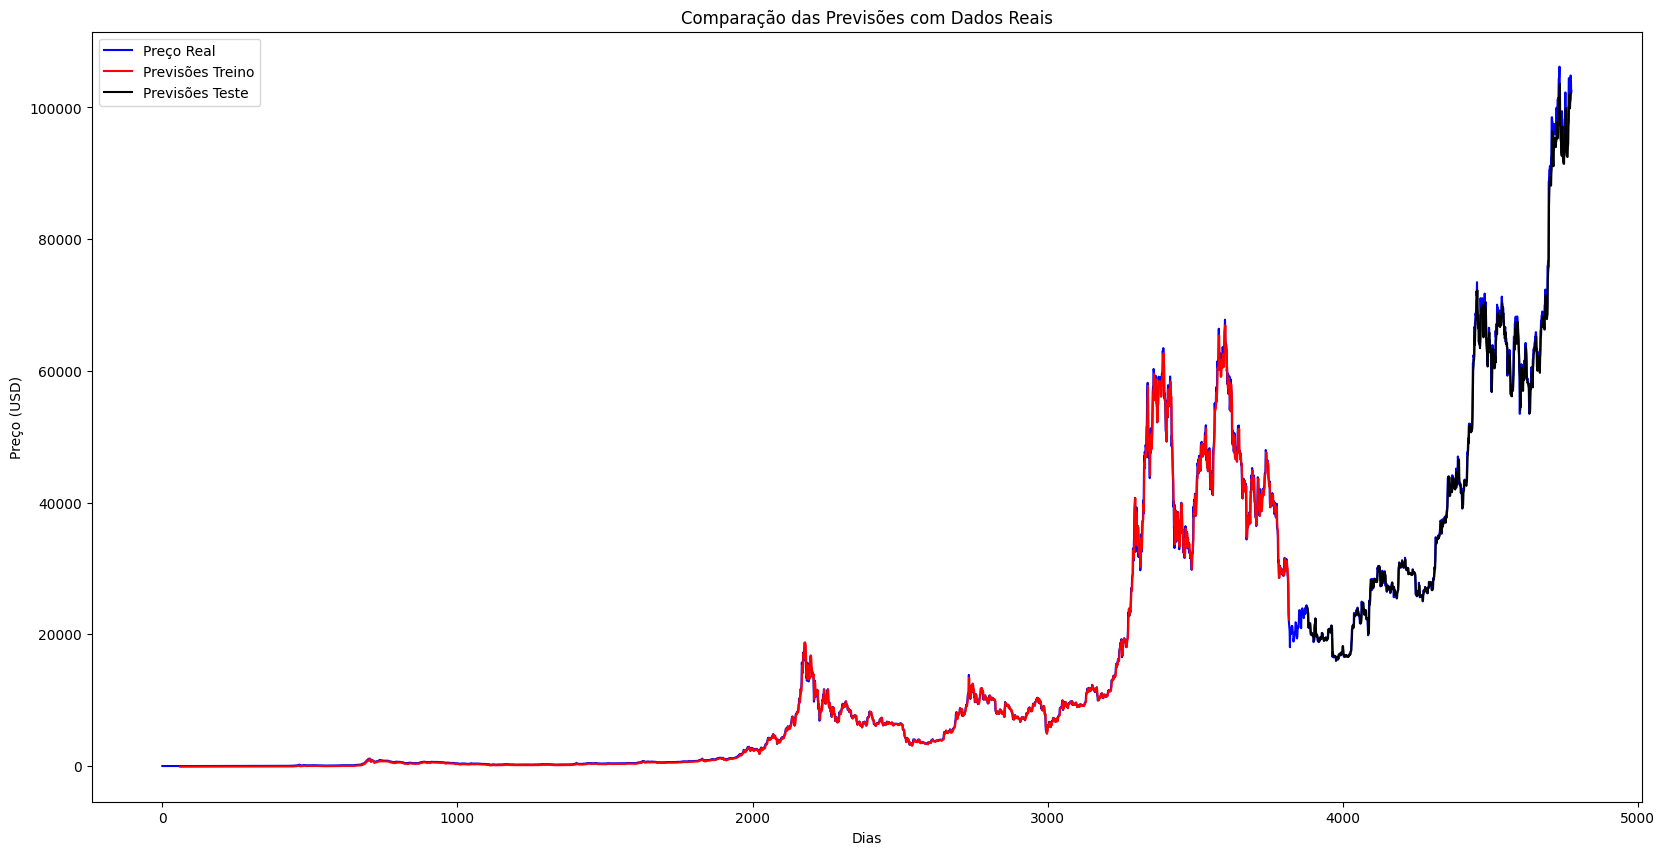

In [18]:
# Plotar tudo
# Plot dos resultados
plt.figure(figsize=(20,10))

plt.plot(data, label='Preço Real', color = 'blue')
plt.plot(train_plot, label='Previsões Treino', color = 'red')
plt.plot(test_plot, label='Previsões Teste', color= 'black')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

## 8. Previsão Futura (Exemplo)

In [59]:
def predict_future(model, df_daily, scaler, seq_length=60, days=30):
    # Pegar últimos dados conhecidos
    last_known = df_daily[-seq_length:]['Close'].values
    
    # Normalizar
    last_known_scaled = scaler.transform(last_known.reshape(-1, 1))
    
    predictions = []
    current_sequence = last_known_scaled.reshape(-1)
    
    for _ in range(days):
        # Fazer previsão
        current_seq_reshaped = current_sequence[-seq_length:].reshape(1, seq_length, 1)
        next_pred = model.predict(current_seq_reshaped, verbose=0)
        
        # Adicionar à lista de previsões
        predictions.append(next_pred[0,0])
        
        # Atualizar sequência mantendo mais contexto histórico
        current_sequence = np.append(current_sequence, next_pred)
    
    # Desnormalizar previsões
    future_pred_transformed = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # Criar datas futuras
    last_date = df_daily.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)
    
    return pd.DataFrame(future_pred_transformed, index=future_dates, columns=['Predicted_Price'])

# Uso:
future_df = predict_future(model, df_daily, scaler)



In [61]:
# Última sequência dos dados de teste
last_sequence = scaled_data[-SEQ_LENGTH:]

# Gerar previsões para 30 dias
future_predictions = future_df['Predicted_Price']
print("Previsões para os próximos 30 dias:")
print(future_predictions)

Previsões para os próximos 30 dias:
2025-01-28    100110.101562
2025-01-29     98190.562500
2025-01-30     96298.226562
2025-01-31     94459.906250
2025-02-01     92690.273438
2025-02-02     90994.875000
2025-02-03     89374.421875
2025-02-04     87827.046875
2025-02-05     86349.585938
2025-02-06     84938.296875
2025-02-07     83589.312500
2025-02-08     82298.765625
2025-02-09     81062.976562
2025-02-10     79878.507812
2025-02-11     78742.156250
2025-02-12     77650.953125
2025-02-13     76602.179688
2025-02-14     75593.328125
2025-02-15     74622.085938
2025-02-16     73686.351562
2025-02-17     72784.156250
2025-02-18     71913.703125
2025-02-19     71073.312500
2025-02-20     70261.429688
2025-02-21     69476.617188
2025-02-22     68717.539062
2025-02-23     67982.921875
2025-02-24     67271.617188
2025-02-25     66582.515625
2025-02-26     65914.585938
Freq: D, Name: Predicted_Price, dtype: float32


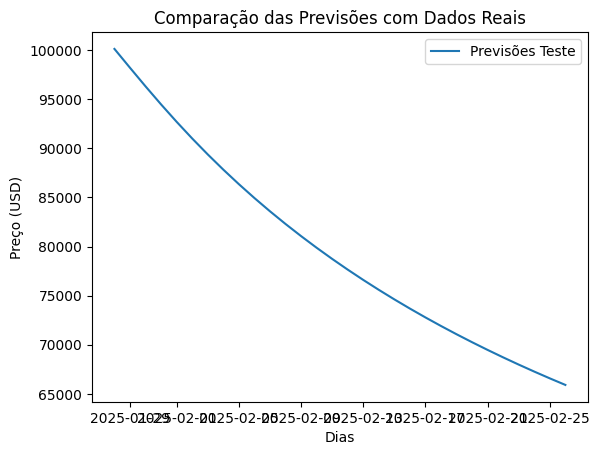

In [62]:
plt.plot(future_predictions, label='Previsões Teste')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

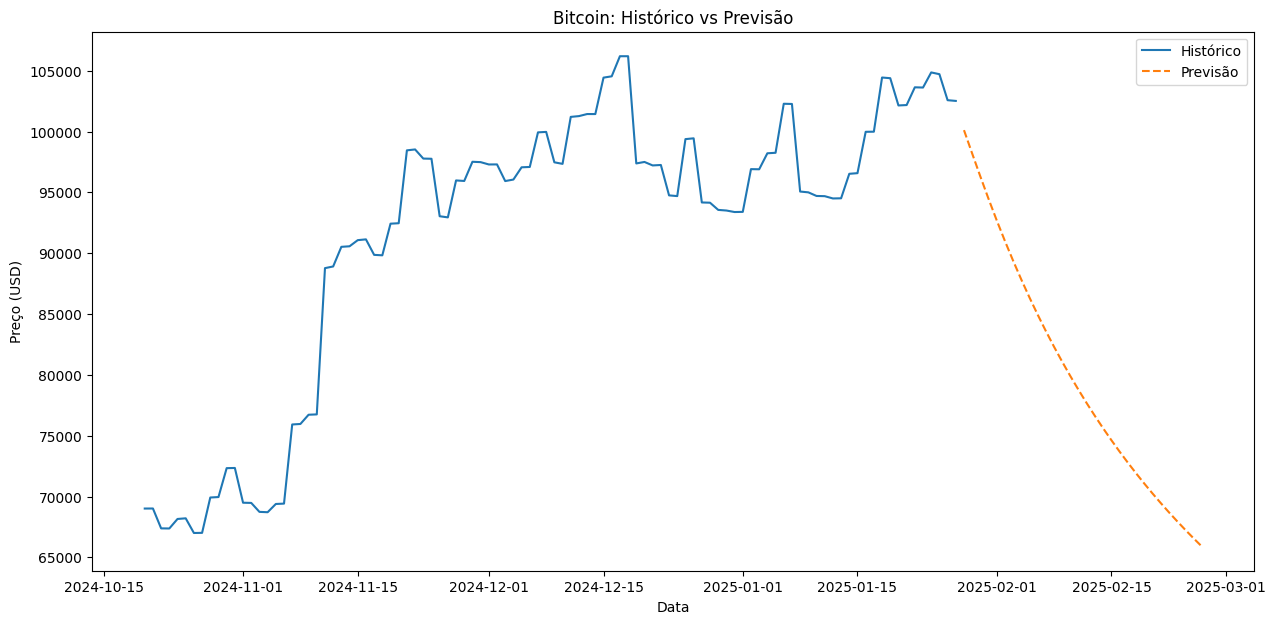

In [63]:

# Plotar resultados
plt.figure(figsize=(15,7))
plt.plot(df_daily.index[-100:], df_daily['Close'][-100:], label='Histórico')
plt.plot(future_df.index, future_df['Predicted_Price'], label='Previsão', linestyle='--')
plt.title('Bitcoin: Histórico vs Previsão')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

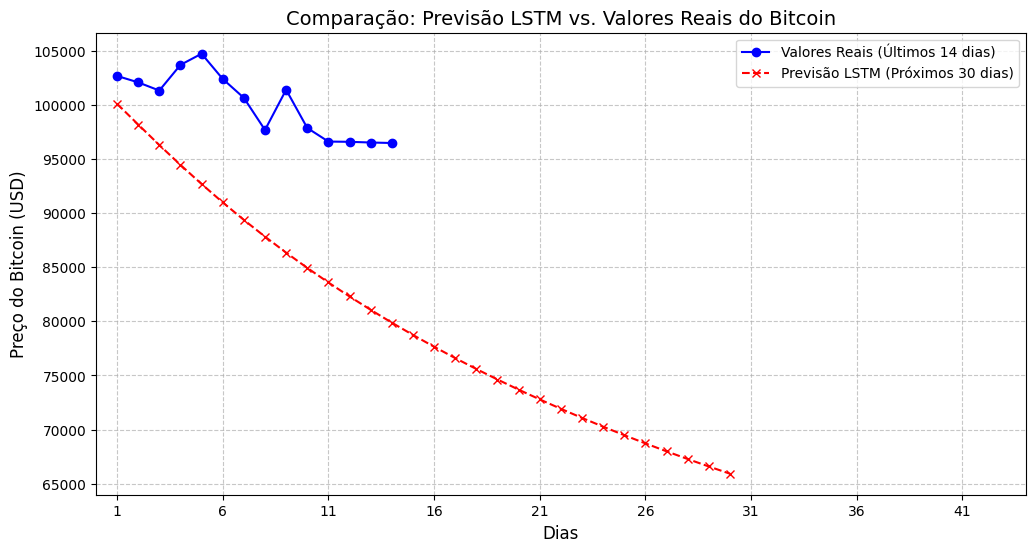

In [64]:
future_predictions = future_df['Predicted_Price'] 
# Simulação dos valores reais dos últimos 14 dias (ajuste conforme os dados reais)
valores_reais = [
    102682.50, 102087.69, 101332.48, 103703.21, 104735.30, 102405.03, 100655.91, 97688.98, 101405.42, 97871.82,
    96615.44, 96593.30, 96529.08, 96482.45
]

dias_reais = np.arange(1, 15)  # Últimos 14 dias
dias_previsao = np.arange(1, 31)  # Próximos 30 dias

# Plotando o gráfico
plt.figure(figsize=(12, 6))

# Linha dos valores reais
plt.plot(dias_reais, valores_reais, label="Valores Reais (Últimos 14 dias)", color="blue", marker="o")

# Linha das previsões do LSTM
plt.plot(dias_previsao, future_predictions, label="Previsão LSTM (Próximos 30 dias)", color="red", linestyle="--", marker="x")

# Configurações do gráfico
plt.title("Comparação: Previsão LSTM vs. Valores Reais do Bitcoin", fontsize=14)
plt.xlabel("Dias", fontsize=12)
plt.ylabel("Preço do Bitcoin (USD)", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# Ajustando os limites do eixo X
plt.xlim(0, 44)
plt.xticks(np.arange(1, 45, 5))  # Marcadores a cada 5 dias

# Exibindo o gráfico
plt.show()